In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import cv2
import re
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import sklearn
from sklearn.model_selection import train_test_split


c:\Users\thepr\.conda\envs\tf_exec_2.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.196  Python-3.10.13 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Setup complete  (20 CPUs, 15.7 GB RAM, 762.3/931.5 GB disk)


In [3]:
PRODUCT_DIR = "./src/product_detection_from_packshots/product_images/"
SHELF_DIR = "./src/product_detection_from_packshots/shelf_images/"

print("There are {} product images and {} shelf images".format(len(os.listdir(PRODUCT_DIR)),len(os.listdir(SHELF_DIR))))


There are 300 product images and 3153 shelf images


In [4]:
model = ultralytics.YOLO('yolov8n.pt')

source = "src/product_detection_from_packshots/shelf_images/"
output = "detected_shelf_objects"
img_size = 640

results = model.predict(source, save_txt=True, imgsz=img_size, save_dir=output)

In [5]:
PRODUCTS = os.listdir(PRODUCT_DIR)

In [6]:
PRODUCTS = sorted(PRODUCTS,key=lambda x : [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)',x)] )
PRODUCTS

['qr1.jpg',
 'qr2.jpg',
 'qr3.jpg',
 'qr4.jpg',
 'qr5.jpg',
 'qr6.jpg',
 'qr7.jpg',
 'qr8.jpg',
 'qr9.jpg',
 'qr10.jpg',
 'qr11.jpg',
 'qr12.jpg',
 'qr13.jpg',
 'qr14.jpg',
 'qr15.jpg',
 'qr16.jpg',
 'qr17.jpg',
 'qr18.jpg',
 'qr19.jpg',
 'qr20.jpg',
 'qr21.jpg',
 'qr22.jpg',
 'qr23.jpg',
 'qr24.jpg',
 'qr25.jpg',
 'qr26.jpg',
 'qr27.jpg',
 'qr28.jpg',
 'qr29.jpg',
 'qr30.jpg',
 'qr31.jpg',
 'qr32.jpg',
 'qr33.jpg',
 'qr34.jpg',
 'qr35.jpg',
 'qr36.jpg',
 'qr37.jpg',
 'qr38.jpg',
 'qr39.jpg',
 'qr40.jpg',
 'qr41.jpg',
 'qr42.jpg',
 'qr43.jpg',
 'qr44.jpg',
 'qr45.jpg',
 'qr46.jpg',
 'qr47.jpg',
 'qr48.jpg',
 'qr49.jpg',
 'qr50.jpg',
 'qr51.jpg',
 'qr52.jpg',
 'qr53.jpg',
 'qr54.jpg',
 'qr55.jpg',
 'qr56.jpg',
 'qr57.jpg',
 'qr58.jpg',
 'qr59.jpg',
 'qr60.jpg',
 'qr61.jpg',
 'qr62.jpg',
 'qr63.jpg',
 'qr64.jpg',
 'qr65.jpg',
 'qr66.jpg',
 'qr67.jpg',
 'qr68.jpg',
 'qr69.jpg',
 'qr70.jpg',
 'qr71.jpg',
 'qr72.jpg',
 'qr73.jpg',
 'qr74.jpg',
 'qr75.jpg',
 'qr76.jpg',
 'qr77.jpg',
 'qr78.j

(1704, 2272, 3)


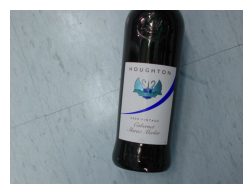

In [7]:
plt.figure(figsize=(3,3))
plt.axis("off")
for img in os.listdir(PRODUCT_DIR):
    img_arr = cv2.imread(os.path.join(PRODUCT_DIR,img))
    plt.imshow(img_arr)
    print(img_arr.shape)
    break

In [8]:
PRODUCT_LABELS = [str(label) for label in range(1,101)]

In [9]:
df = pd.DataFrame(columns=["PRODUCT_ID","PATH"],)

In [11]:
cur_id = 0
cur_product = PRODUCTS[cur_id]

for product_id, product in enumerate(PRODUCTS):
    path  = os.path.join(PRODUCT_DIR,product)
    _,id,_ = re.split('([0-9]+)',product)
    if(int(id) != 0) and (int(id)%3 == 0):
        df.loc[product_id,"PRODUCT_ID"] = PRODUCT_LABELS[cur_id]
        df.loc[product_id,"PATH"] = path
        cur_id += 1
    else:
        df.loc[product_id,"PRODUCT_ID"] = PRODUCT_LABELS[cur_id]
        df.loc[product_id,"PATH"] = path


In [12]:
df

PRODUCT_ID                                               PATH
0            1  ./src/product_detection_from_packshots/product...
1            1  ./src/product_detection_from_packshots/product...
2            1  ./src/product_detection_from_packshots/product...
3            2  ./src/product_detection_from_packshots/product...
4            2  ./src/product_detection_from_packshots/product...
..         ...                                                ...
295         99  ./src/product_detection_from_packshots/product...
296         99  ./src/product_detection_from_packshots/product...
297        100  ./src/product_detection_from_packshots/product...
298        100  ./src/product_detection_from_packshots/product...
299        100  ./src/product_detection_from_packshots/product...

[300 rows x 2 columns]

In [13]:
img_list = []
labels_list = []
(w,h) = (1200,1200)
for img_id_, path in enumerate(df['PATH']):
  img_ = plt.imread(path)
  center = [el/2 for el in img_.shape[:2]]
  x = center[1] - w/2
  y = center[0] - h/2
  img_ = img_[int(y):int(y+h), int(x):int(x+w)]
  img_ = tf.keras.preprocessing.image.smart_resize(img_, size = (256,256), interpolation='bicubic')
  img_-=img_.min()
  img_/=(img_.max()-img_.min())
  img_list.append(img_)
  labels_list.append(df['PRODUCT_ID'][img_id_])

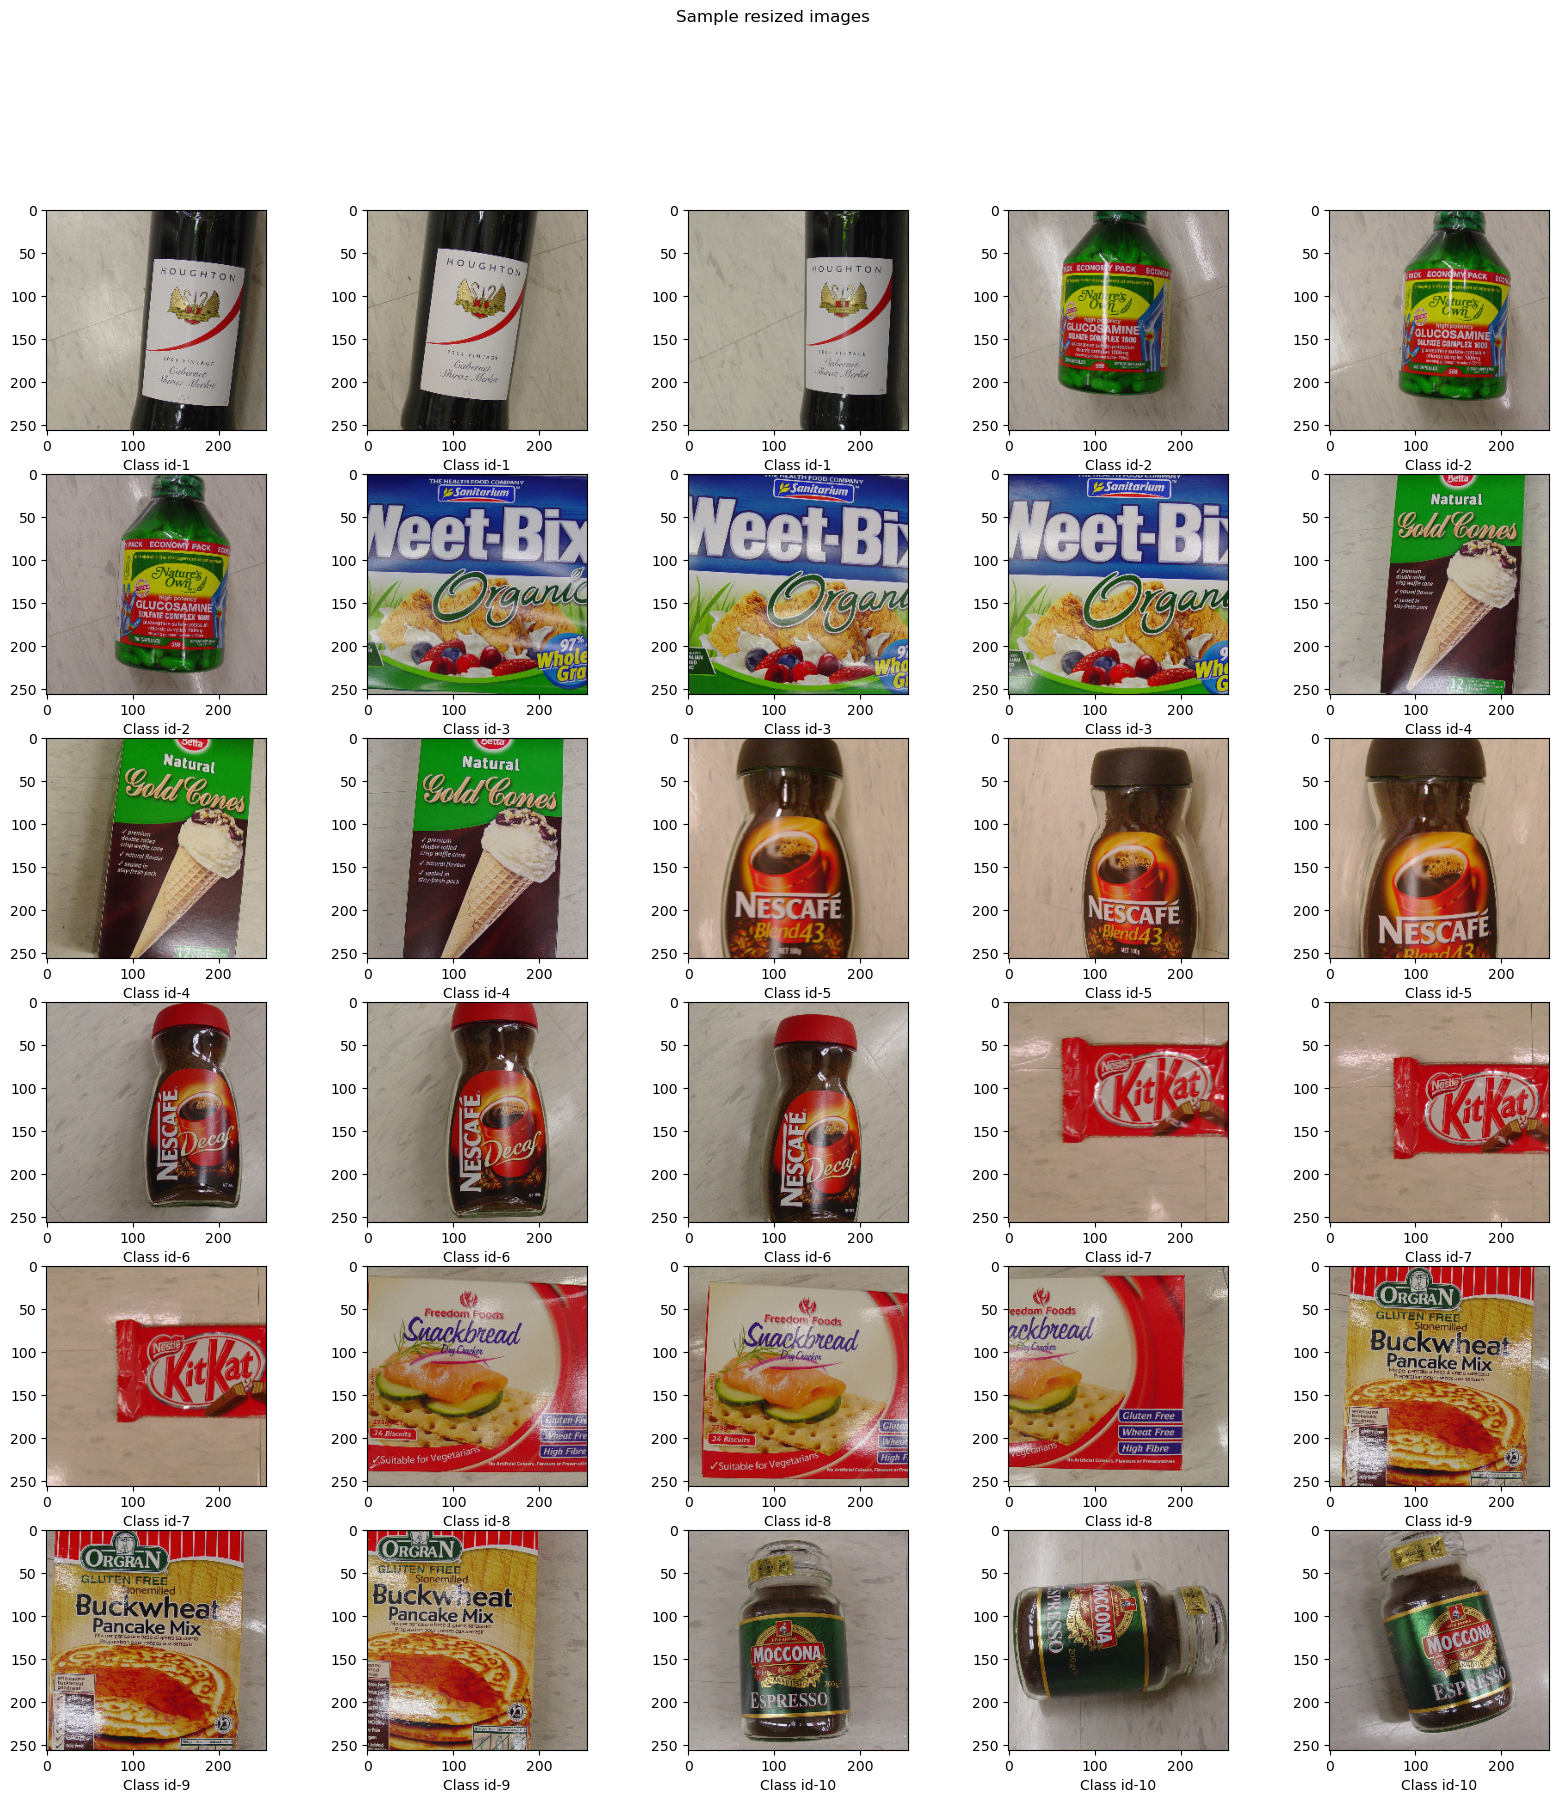

In [14]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Sample resized images')
for i in range(30):
  fig.add_subplot(6,5,i+1)
  plt.imshow(img_list[i])
  plt.xlabel(f'Class id-{labels_list[i]}')

In [15]:
img_array = np.array(img_list, dtype = np.float32)
label_array = np.array(labels_list, dtype = np.int32)

In [17]:
from PIL import Image, ImageOps

In [18]:
class AutoEnhanceColor:
    def __call__(self, img_tensor):
        enhanced_img_tensor = img_tensor * 1.5  
        enhanced_img_tensor = torch.clamp(enhanced_img_tensor, 0.0, 1.0)  
        return enhanced_img_tensor

In [19]:
class AutoBrightness:
    def __call__(self, img_tensor):
        # Assuming img_tensor has shape (C, H, W)
        brightness_factor = torch.rand(1) + 0.5  # You can adjust the brightness factor
        enhanced_img_tensor = img_tensor * brightness_factor
        enhanced_img_tensor = torch.clamp(enhanced_img_tensor, 0.0, 1.0)  # Ensure values are in the [0, 1] range
        return enhanced_img_tensor


In [20]:
class AutoEqualize:
    def __call__(self, img_tensor):
        # Assuming img_tensor has shape (C, H, W)
        img_pil = transforms.ToPILImage()(img_tensor)  # Convert to PIL Image
        equalized_img_pil = ImageOps.equalize(img_pil)  # Equalize histogram
        equalized_img_tensor = transforms.ToTensor()(equalized_img_pil)
        return equalized_img_tensor

In [21]:
def augment(dataset, label, class_idx = 1):
    
    idx_list = list(np.where(label == class_idx)[0])

    data_transforms_list = [transforms.RandomAutocontrast(),
                            AutoBrightness(),
                            transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                            AutoEqualize(),
                            AutoEnhanceColor(),
                            transforms.RandomRotation(5),
                            transforms.RandomAutocontrast(),
                            AutoBrightness(),
                            transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                            AutoEqualize(),
                            AutoEnhanceColor(),
                            transforms.RandomRotation(5),
                            ]
    aug_img_list = []
    aug_label_list = []

    for idx in idx_list:

        for transform in data_transforms_list:
            img = dataset[idx]
            img_tensor = transforms.ToTensor()(img)
            transform = transforms.Compose([transform])
            aug_img_tensor = transform(img_tensor)
            print(f"Transform: {transform}, DataType: {aug_img_tensor.dtype}")
           
            pil_img = transforms.ToPILImage()(aug_img_tensor)
            # pil_img.show()  # Display the PIL Image
            aug_img = np.array(pil_img.convert("RGB"))
            # plt.imshow(aug_img)
            # print(aug_img.shape)
            
            aug_img_list.append(aug_img)
            aug_label_list.append(class_idx)

    aug_img_array = np.array(aug_img_list, dtype=np.float32) / np.float32(255.0)
    print(aug_img_array.min(), aug_img_array.max(), aug_img_array.dtype)
    aug_label_array = np.array(aug_label_list, dtype=np.int32)


    return aug_img_array, aug_label_array

In [22]:
list(np.where(label_array == 2)[0])

[3, 4, 5]

In [ ]:
aug_img_final = np.array([])
aug_label_final = np.array([])
for cls in list(range(1,101)):
    aug_img_cls, aug_label_cls = augment(img_array, label_array, class_idx=cls)

    # Concatenate the augmented images and labels for the current class
    aug_img_final = np.concatenate([aug_img_final, aug_img_cls]) if aug_img_final.size else aug_img_cls
    aug_label_final = np.concatenate([aug_label_final, aug_label_cls]) if aug_label_final.size else aug_label_cls

In [24]:
aug_img_final.shape

(3600, 256, 256, 3)

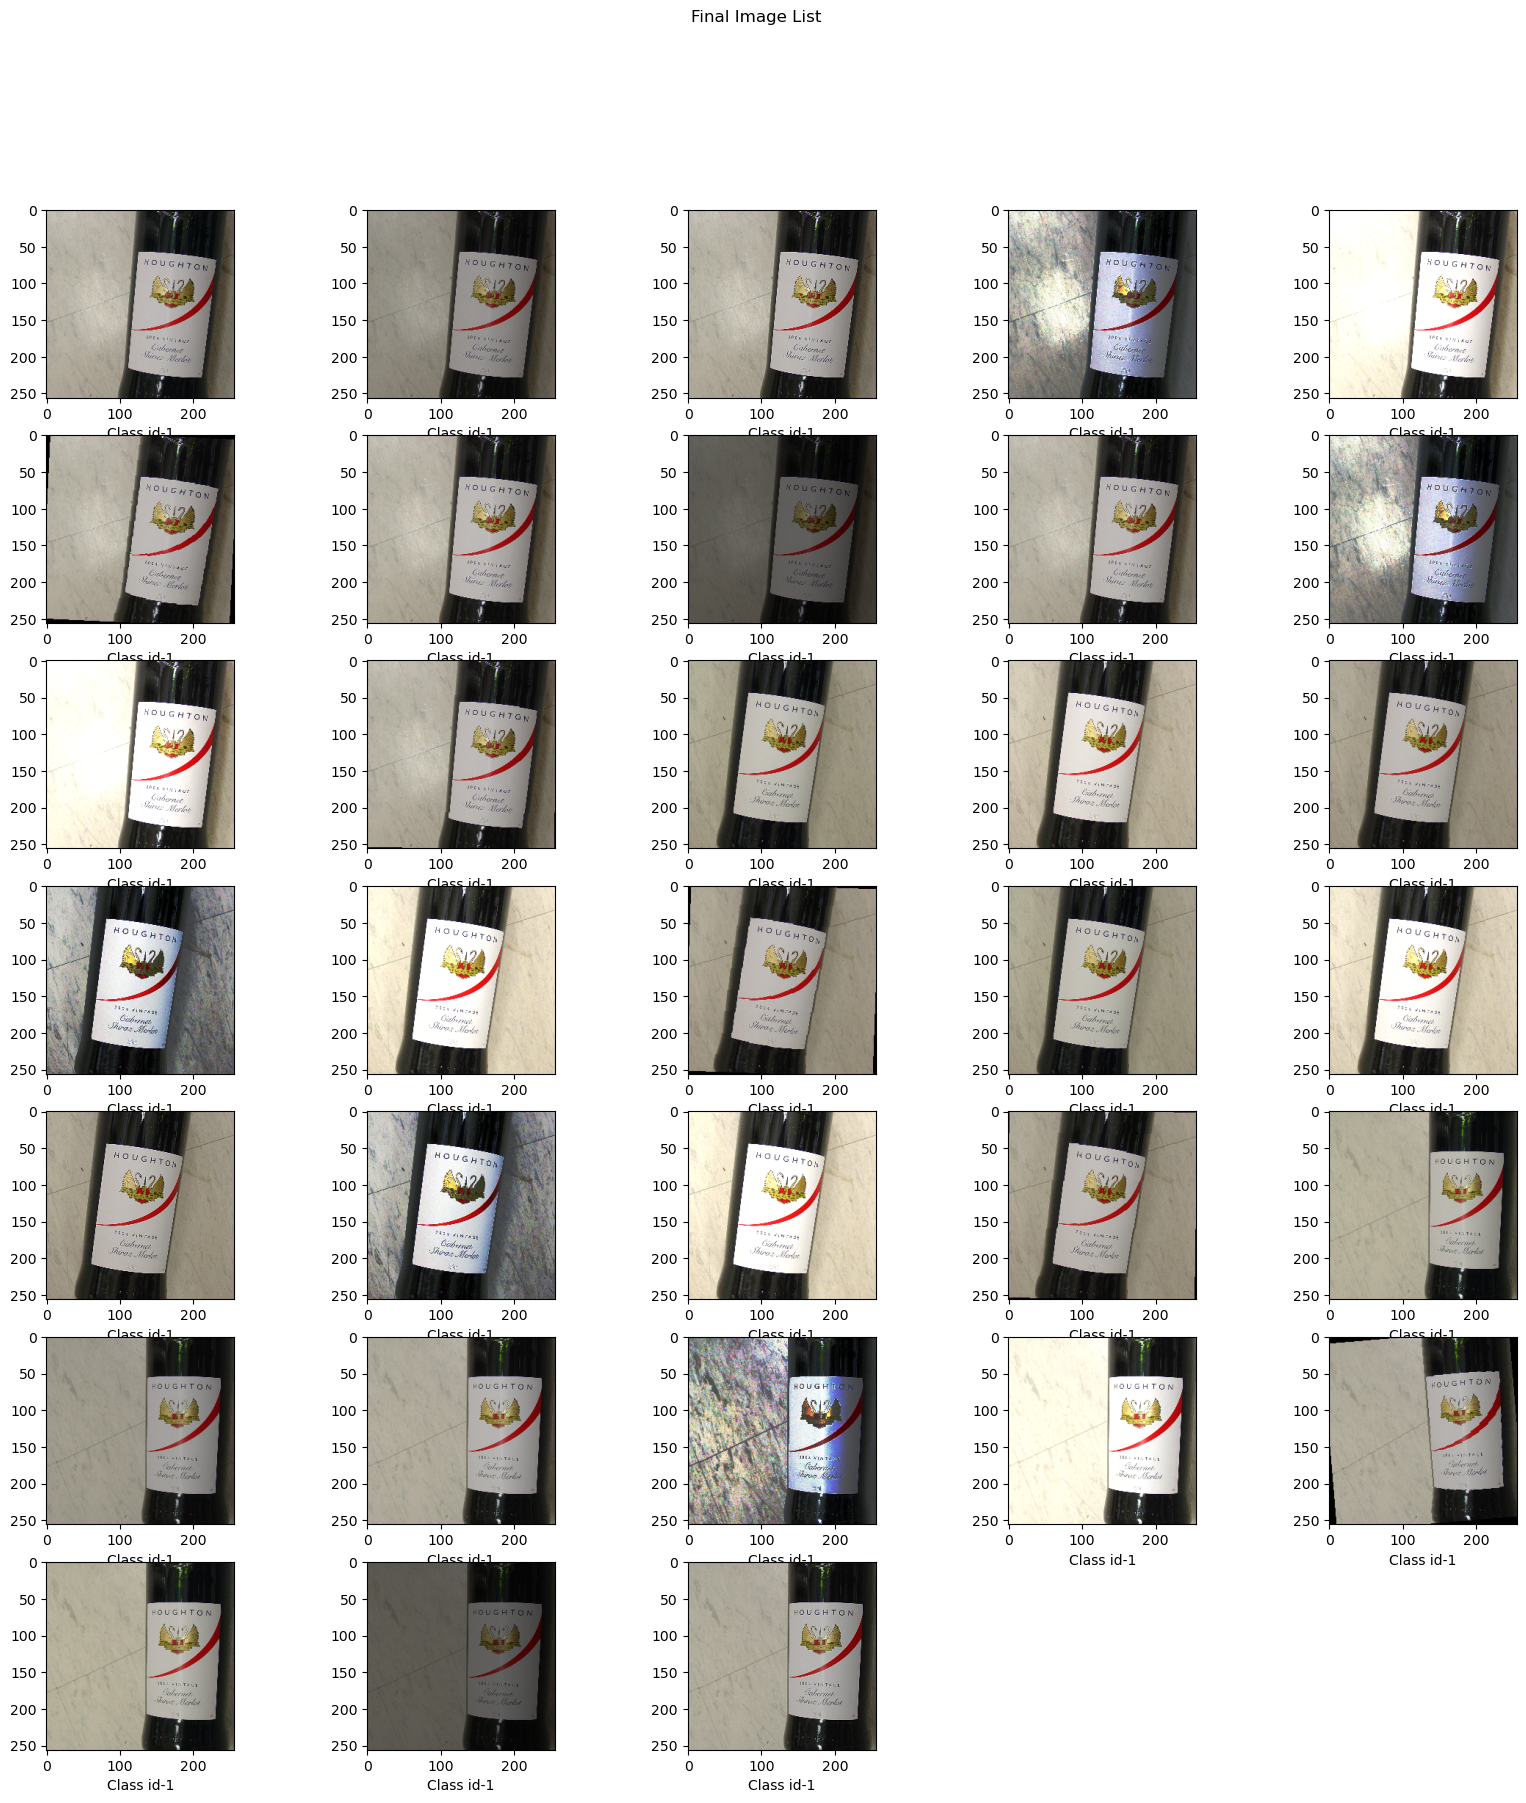

In [25]:
# plot 30 sample images
fig = plt.figure(figsize=(20,20))
fig.suptitle('Final Image List')
for i in range(30):
  fig.add_subplot(7,5,i+1)
  plt.imshow(aug_img_final[i])
  plt.xlabel(f'Class id-{aug_label_final[i]}')

In [26]:
X_train, X_val_test, y_train, y_val_test = train_test_split(aug_img_final, aug_label_final,
                                                            stratify=aug_label_final,
                                                            test_size= 0.1665,shuffle=True,
                                                            random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test,
                                                            stratify=y_val_test,
                                                            test_size= 0.5,shuffle=True,
                                                            random_state=42)

In [27]:
print(f'Train set dimension and datatype {X_train.shape, X_train.dtype, y_train.shape, y_train.dtype}')
print(f'Validation set dimension {X_val.shape, X_val.dtype, y_val.shape, y_val.dtype}')
print(f'Test set dimension and datatype {X_test.shape, X_test.dtype, y_test.shape, y_test.dtype}')

Train set dimension and datatype ((3000, 256, 256, 3), dtype('float32'), (3000,), dtype('int32'))
Validation set dimension ((300, 256, 256, 3), dtype('float32'), (300,), dtype('int32'))
Test set dimension and datatype ((300, 256, 256, 3), dtype('float32'), (300,), dtype('int32'))


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [39]:
def create_resnet50v2_model():
  conv_base = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(256, 256, 3),
    pooling='avg'
  )
  
  model = Sequential()
  model.add(conv_base)
  model.add(Dense(100, activation='softmax'))

  return model

In [40]:
model = create_resnet50v2_model()

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_1 (Dense)             (None, 100)               204900    
                                                                 
Total params: 23,769,700
Trainable params: 23,724,260
Non-trainable params: 45,440
_________________________________________________________________


In [32]:
def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

In [42]:
conv_base = model.get_layer('resnet50v2')

In [34]:
# conv_base.summary()

In [43]:
freeze_model(conv_base)

for layer in conv_base.layers:
 if layer.name.startswith('conv5_block2') or layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
   layer.trainable = True
   
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_1 (Dense)             (None, 100)               204900    
                                                                 
Total params: 23,769,700
Trainable params: 9,138,276
Non-trainable params: 14,631,424
_________________________________________________________________


In [36]:
# conv_base.summary()

In [37]:
# for layer in conv_base.layers:
#  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
#    layer.trainable = True

In [38]:
# model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [39]:
# model.summary()

In [44]:
CP = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',verbose = 1, save_best_only=True, save_freq=375, mode ='min')

In [45]:
history = model.fit(x = X_train, y = y_train, batch_size= 16, epochs = 10, verbose=1, validation_data=(X_val,y_val))

Epoch 1/10
188/188 [==============================] - 13s 47ms/step - loss: nan - accuracy: 0.0070 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
188/188 [==============================] - 8s 40ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
188/188 [==============================] - 8s 41ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
188/188 [==============================] - 8s 41ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
188/188 [==============================] - 8s 41ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
188/188 [==============================] - 8s 41ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
188/188 [==============================] - 8s 41ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: